# Model Evaluation & Fine-Tuning
* Choosing the right model, and improving its performance

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle
from sklearn import metrics
from pandas.tools.plotting import scatter_matrix
from IPython.display import display

%matplotlib inline

In [2]:
boston = datasets.load_boston()
print(type(boston)) # A 'Bunch' is a special obj in python, similar to a dict
print(boston.keys())

<class 'sklearn.utils.Bunch'>
dict_keys(['data', 'target', 'feature_names', 'DESCR'])


In [3]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [4]:
features = boston['feature_names']
boston_df = pd.DataFrame(boston['data'], columns=features)
boston_df['MEDV'] = pd.Series(boston['target'])
print(features)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [5]:
target = pd.Series(boston['target'])
print('min, max = ', target.min(), ',', target.max())
print('mean = ', target.mean())
print('std = ', target.std())

# target values are in thousands of USD

min, max =  5.0 , 50.0
mean =  22.532806324110698
std =  9.19710408737982


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002344B3EA470>,
      dtype=object)

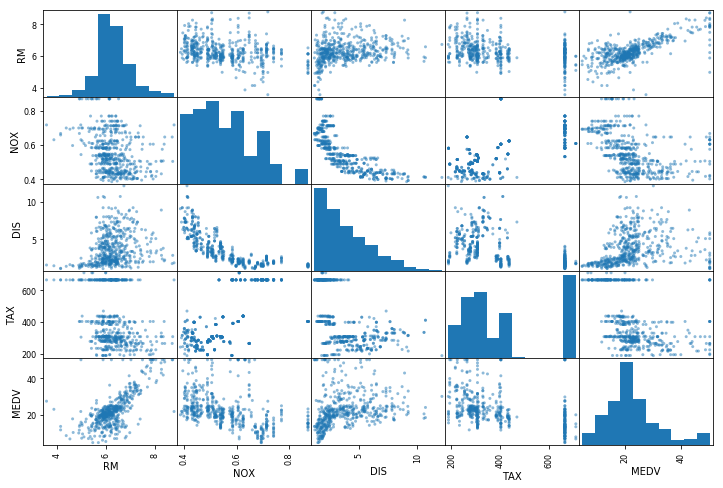

In [6]:
# too many features to neatly visualize in a scatter mx. Let's pick a few we think will be good predictors
features_we_care_abt = ['RM', 'NOX', 'DIS', 'TAX', 'MEDV']
scatter_matrix(boston_df[features_we_care_abt], figsize=(12,8))

In [7]:
corr_mx = boston_df.corr()
corr_mx['MEDV'].sort_values(ascending=False)

MEDV       1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.385832
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64

In [8]:
data, target = shuffle(boston['data'], boston['target'])

X_train, X_test = data[:400], data[400:]
y_train, y_test = target[:400], target[400:]
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(400, 13) (106, 13)
(400,) (106,)


In [9]:
lin_reg = LinearRegression()
d_tree = DecisionTreeRegressor()

lin_reg.fit(X_train, y_train)
d_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

# Evaluate on Test Set

In [10]:
y_pred_lin = lin_reg.predict(X_test)
y_pred_tree = d_tree.predict(X_test)

def RMSE(MSE):
    """Root-Mean-Squared Error"""
    return np.sqrt(abs(MSE))

MSE_lin = metrics.mean_squared_error(y_test, y_pred_lin)
MSE_tree = metrics.mean_squared_error(y_test, y_pred_tree)

print('LinReg MSE: ', MSE_lin)
print('D Tree MSE: ', MSE_tree)
print()
print('LinReg RMSE: ', RMSE(MSE_lin))
print('D Tree RMSE: ', RMSE(MSE_tree))

LinReg MSE:  23.921011359005863
D Tree MSE:  19.000188679245284

LinReg RMSE:  4.8909110970253655
D Tree RMSE:  4.3589205864807035


# Cross Validation

In [11]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Std Dev: ", scores.std())
    print("Mean RMSE: ", RMSE(scores.mean()))

scores_tree = cross_val_score(d_tree, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
scores_lin = cross_val_score(lin_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Decision Tree:")
display_scores(scores_tree)
print("\nLinear Regression:")
display_scores(scores_lin)

Decision Tree:
Scores:  [-34.65775  -18.84625  -22.027875 -12.64975  -16.240625]
Mean:  -20.884449999999998
Std Dev:  7.543750626594837
Mean RMSE:  4.569950765599121

Linear Regression:
Scores:  [-24.14632496 -32.64109898 -25.88726248 -20.64000621 -19.49767706]
Mean:  -24.562473936569155
Std Dev:  4.652533667922115
Mean RMSE:  4.956054270946713


# Fine Tuning with Grid Search

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'max_depth': [2,5,None], 'min_samples_leaf': [1, 5, 10, 20]}
]

grid_search = GridSearchCV(d_tree, param_grid, cv=5, scoring='neg_mean_squared_error')

In [13]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': [2, 5, None], 'min_samples_leaf': [1, 5, 10, 20]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [14]:
grid_search.best_params_

{'max_depth': None, 'min_samples_leaf': 5}

In [15]:
best_tree = grid_search.best_estimator_
best_tree.fit(X_train, y_train) # refit on whole training set
y_pred_gridSearch = best_tree.predict(X_test)

cv_res = pd.DataFrame(grid_search.cv_results_)
display(cv_res[['params', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']])

print('Grid Search MSE: ', metrics.mean_squared_error(y_test, y_pred_gridSearch))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,"{'max_depth': 2, 'min_samples_leaf': 1}",-24.440349,1.404173,-29.545174,5.988154
1,"{'max_depth': 2, 'min_samples_leaf': 5}",-24.440349,1.404173,-29.545174,5.988154
2,"{'max_depth': 2, 'min_samples_leaf': 10}",-24.440349,1.404173,-29.545174,5.988154
3,"{'max_depth': 2, 'min_samples_leaf': 20}",-24.973878,1.448418,-30.899738,5.456686
4,"{'max_depth': 5, 'min_samples_leaf': 1}",-5.356492,0.127306,-23.087854,4.841232
5,"{'max_depth': 5, 'min_samples_leaf': 5}",-10.044671,1.227506,-19.563757,6.133002
6,"{'max_depth': 5, 'min_samples_leaf': 10}",-12.648609,1.366597,-19.984043,6.273124
7,"{'max_depth': 5, 'min_samples_leaf': 20}",-15.528004,1.439412,-22.663001,4.806656
8,"{'max_depth': None, 'min_samples_leaf': 1}",0.000000,0.000000,-23.895050,8.848213
9,"{'max_depth': None, 'min_samples_leaf': 5}",-7.708828,1.115591,-18.684796,5.787903


Grid Search MSE:  22.202363893479305


# Ensemble Methods

* Averaging predictions from several models to get a better result
* "Wisdom of the crowd"

**Random Forest**: A collection of Decision Trees, all with randomized hyper-parameters

In [16]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
forest.fit(X_train, y_train)

scores_forest = cross_val_score(forest, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
display_scores(scores_forest)

y_pred_forest = forest.predict(X_test)
MSE_forest = metrics.mean_squared_error(y_test, y_pred_forest)
print('Test MSE: ', MSE_forest)
print('Test RMSE: ', RMSE(MSE_forest))

Scores:  [-16.5563875  -19.26936125 -14.41637625  -9.92418125  -8.88522125]
Mean:  -13.810305500000002
Std Dev:  3.926015648017051
Mean RMSE:  3.716221939012793
Test MSE:  15.458379245283018
Test RMSE:  3.931714542700553


# Grid Search CV on Random Forest

In [17]:
param_grid_forest = [
    {'n_estimators': [3, 10, 30], 'max_features': [2,4,6,8]}
]

grid_search_forest = GridSearchCV(forest, param_grid_forest, cv=5, scoring='neg_mean_squared_error')
grid_search_forest.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [18]:
print(grid_search_forest.best_params_)
print(grid_search_forest.best_estimator_)

{'max_features': 6, 'n_estimators': 30}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [19]:
cv_res_forest = pd.DataFrame(grid_search_forest.cv_results_)
display(cv_res_forest[['params', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,"{'max_features': 2, 'n_estimators': 3}",-5.136582,0.848664,-16.221823,3.791088
1,"{'max_features': 2, 'n_estimators': 10}",-2.731832,0.405336,-13.747200,3.232681
2,"{'max_features': 2, 'n_estimators': 30}",-2.118254,0.304652,-13.772728,4.924143
3,"{'max_features': 4, 'n_estimators': 3}",-5.227262,0.530332,-17.165600,5.049553
4,"{'max_features': 4, 'n_estimators': 10}",-2.316075,0.254102,-13.736825,3.766067
5,"{'max_features': 4, 'n_estimators': 30}",-1.907345,0.340244,-12.263674,4.384851
6,"{'max_features': 6, 'n_estimators': 3}",-5.025433,0.552472,-15.321369,4.871515
7,"{'max_features': 6, 'n_estimators': 10}",-2.272204,0.449386,-13.537861,3.404072
8,"{'max_features': 6, 'n_estimators': 30}",-1.799139,0.043127,-11.028946,3.545640
9,"{'max_features': 8, 'n_estimators': 3}",-4.851008,1.040057,-16.782964,7.022004


# Feature Importance

In [20]:
feature_importances = grid_search_forest.best_estimator_.feature_importances_
feature_importances = dict(sorted(zip(feature_importances, features), reverse=True))
feature_importances

{0.3530695274885956: 'RM',
 0.3146491971585103: 'LSTAT',
 0.06496264697276062: 'CRIM',
 0.06167015334030246: 'DIS',
 0.05799338072612576: 'NOX',
 0.0440833669324504: 'PTRATIO',
 0.03728981483861846: 'INDUS',
 0.0184918879363141: 'AGE',
 0.014082024046900132: 'B',
 0.013773420795478645: 'TAX',
 0.007293066818341001: 'ZN',
 0.0072014167303795324: 'CHAS',
 0.005440096215223071: 'RAD'}

In [21]:
# let's try re-training our model on only the 'most important' features
data_pruned = boston_df[['LSTAT', 'RM', 'INDUS', 'PTRATIO']]
data_pruned = data_pruned.values
X_train_pruned, X_test_pruned = data_pruned[:400], data_pruned[400:]
print(X_train_pruned.shape, X_test_pruned.shape)

(400, 4) (106, 4)


In [22]:
forest_p = RandomForestRegressor(max_features=6, n_estimators=30)
forest = RandomForestRegressor(max_features=6, n_estimators=30)

scores_forest = cross_val_score(forest, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
scores_forest_p = cross_val_score(forest_p, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

print('Pruned dataset: ')
display_scores(scores_forest_p)
print()
print('Unmodified dataset: ')
display_scores(scores_forest)

Pruned dataset: 
Scores:  [-11.6461     -19.45809306 -12.33604611  -9.54396708  -8.12950056]
Mean:  -12.222741361111114
Std Dev:  3.9147444180065114
Mean RMSE:  3.4961037400384893

Unmodified dataset: 
Scores:  [-11.50920097 -19.05013944 -13.64189014  -8.44503444  -8.92704194]
Mean:  -12.314661388888885
Std Dev:  3.852971462756046
Mean RMSE:  3.5092251835538972


# Final performance evaluation on Test Set

In [23]:
forest_p.fit(X_train, y_train)
y_pred = forest_p.predict(X_test)

MSE = metrics.mean_squared_error(y_test, y_pred)
print('final MSE: ', MSE)
print('final RMSE: ', RMSE(MSE))


final MSE:  13.584440356394136
final RMSE:  3.6857075787959817
